In this project, we will train a RNN model and make forecasts based on a real-world dataset: [Advance Retail Sales: Clothing and Clothing Accessory Stores](https://fred.stlouisfed.org/series/RSCCASN)

In [1]:
import pandas as pd
import numpy as np

%matplotlib inline
import matplotlib.pyplot as plt

In [2]:
df = pd.read_csv('RSCCASN.csv', index_col='DATE', parse_dates=True, header=0, names=['DATE', 'Sales'])

In [3]:
df.head()

,Sales
DATE,
1992-01-01,6938
1992-02-01,7524
1992-03-01,8475
1992-04-01,9401
1992-05-01,9558


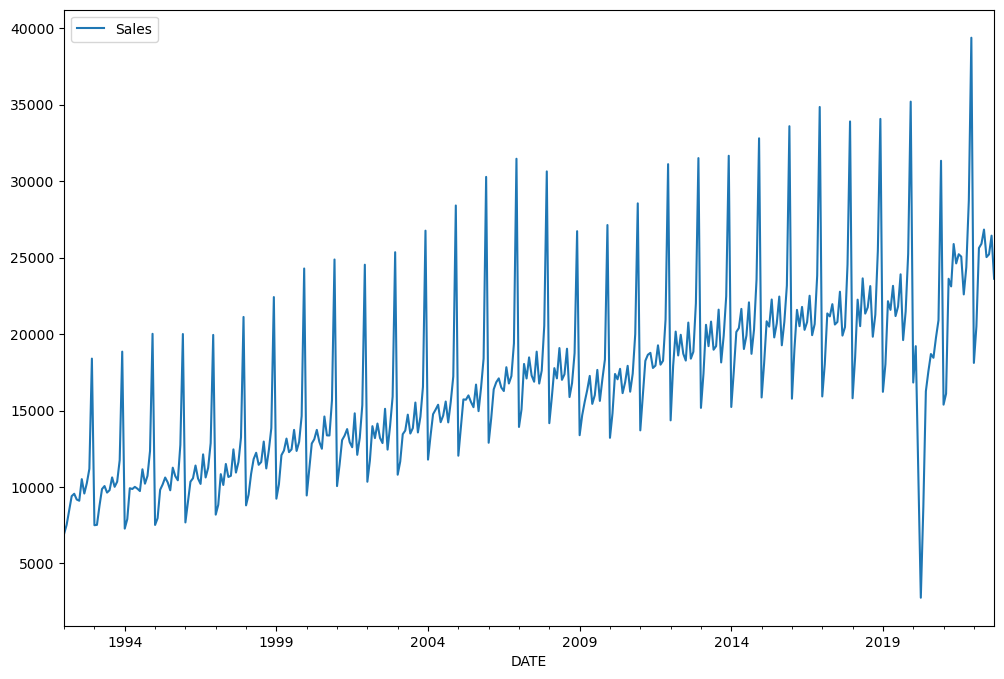

In [4]:
df.plot(figsize=(12,8));

## Train Test Split

In [5]:
test_size = 18
test_idx = len(df) - test_size

In [6]:
train = df.iloc[:test_idx]
test = df.iloc[test_idx:]

## Scale Data

In [7]:
from sklearn.preprocessing import MinMaxScaler

In [8]:
scaler = MinMaxScaler()
train_scaled = scaler.fit_transform(train)
test_scaled = scaler.transform(test)

# Time Series Generator

In [9]:
from tensorflow.keras.preprocessing.sequence import TimeseriesGenerator

In [10]:
# Let's get 12 months back and then predict the next month out

length = 12
generator = TimeseriesGenerator(train_scaled, train_scaled, length=length, batch_size=1)

### Create the Model

In [11]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM
from tensorflow.keras.callbacks import EarlyStopping

In [12]:
# We're only using one feature in our time series
n_features = 1

model = Sequential()
model.add(LSTM(200, activation='relu', input_shape=(length, n_features)))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mse')

2022-10-24 20:41:23.670550: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [13]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 200)               161600    
                                                                 
 dense (Dense)               (None, 1)                 201       
                                                                 
Total params: 161,801
Trainable params: 161,801
Non-trainable params: 0
_________________________________________________________________


### EarlyStopping and creating a Validation Generator

In [14]:
early_stop = EarlyStopping(monitor='val_loss', patience=3)

In [15]:
validation_generator = TimeseriesGenerator(test_scaled, test_scaled, length=length, batch_size=1)

In [16]:
model.fit_generator(generator,epochs=20,
                    validation_data=validation_generator,
                   callbacks=[early_stop])

Epoch 1/20


/var/folders/x3/cmm9kmz16gl8z944wykl78br0000gn/T/ipykernel_2022/3502985036.py:1: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  model.fit_generator(generator,epochs=20,


339/339 [==============================] - 2s 3ms/step - loss: 0.0234 - val_loss: 0.0046
Epoch 2/20
339/339 [==============================] - 1s 3ms/step - loss: 0.0153 - val_loss: 0.0136
Epoch 3/20
339/339 [==============================] - 1s 3ms/step - loss: 0.0093 - val_loss: 0.0018
Epoch 4/20
339/339 [==============================] - 1s 3ms/step - loss: 0.0064 - val_loss: 0.0015
Epoch 5/20
339/339 [==============================] - 1s 3ms/step - loss: 0.0052 - val_loss: 0.0048
Epoch 6/20
339/339 [==============================] - 1s 3ms/step - loss: 0.0061 - val_loss: 0.0042
Epoch 7/20
339/339 [==============================] - 1s 3ms/step - loss: 0.0045 - val_loss: 0.0016


In [17]:
losses = pd.DataFrame(model.history.history)

<AxesSubplot:>

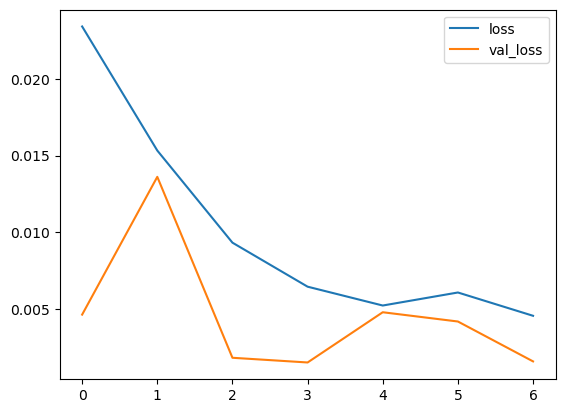

In [18]:
losses.plot()

## Evaluate on Test Data

In [19]:
test_predictions = []
current_batch = train_scaled[-length:].reshape(1,length,n_features)

for _ in range(test_size):
    current_pred = model.predict(current_batch, verbose=0)
    test_predictions.append(current_pred[0])
    
    current_batch = np.append(current_batch[:,1:,:], [current_pred], axis=1)

In [20]:
true_predictions = scaler.inverse_transform(test_predictions)

In [21]:
test['Predictions'] = true_predictions

/var/folders/x3/cmm9kmz16gl8z944wykl78br0000gn/T/ipykernel_2022/4269337381.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test['Predictions'] = true_predictions


<AxesSubplot:xlabel='DATE'>

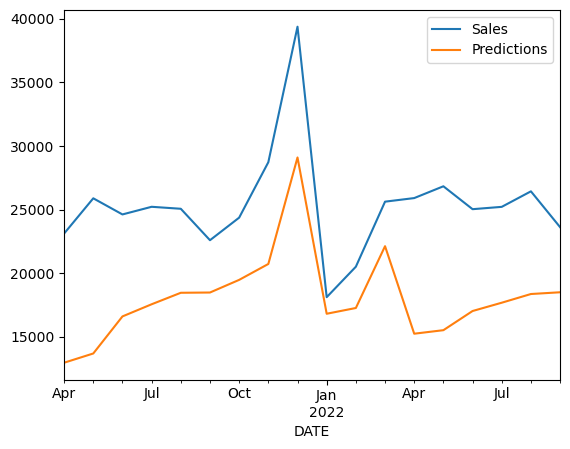

In [22]:
test.plot()

# Retrain and Forecasting

In [23]:
full_scaler = MinMaxScaler()
scaled_full_data = full_scaler.fit_transform(df)

In [24]:
length = 12
generator = TimeseriesGenerator(scaled_full_data, scaled_full_data, length=length, batch_size=1)

In [47]:
n_features = 1

model = Sequential()

model.add(LSTM(200, activation='relu', input_shape=(length, n_features)))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mse')

In [25]:
model.fit_generator(generator, epochs=8)

Epoch 1/8
 34/357 [=>............................] - ETA: 1s - loss: 0.0014

/var/folders/x3/cmm9kmz16gl8z944wykl78br0000gn/T/ipykernel_2022/3321394352.py:1: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  model.fit_generator(generator, epochs=8)


357/357 [==============================] - 1s 3ms/step - loss: 0.0042
Epoch 2/8
357/357 [==============================] - 1s 3ms/step - loss: 0.0044
Epoch 3/8
357/357 [==============================] - 1s 3ms/step - loss: 0.0042
Epoch 4/8
357/357 [==============================] - 1s 3ms/step - loss: 0.0037
Epoch 5/8
357/357 [==============================] - 1s 3ms/step - loss: 0.0039
Epoch 6/8
357/357 [==============================] - 1s 3ms/step - loss: 0.0036
Epoch 7/8
357/357 [==============================] - 1s 3ms/step - loss: 0.0033
Epoch 8/8
357/357 [==============================] - 1s 3ms/step - loss: 0.0033


In [26]:
forecast = []
current_batch = scaled_full_data[-length:].reshape(1,length, n_features)
periods = 12

for _ in range(periods):
    current_pred = model.predict(current_batch, verbose=0)
    forecast.append(current_pred[0])
    
    current_batch = np.append(current_batch[:,1:,:], [current_pred], axis=1)

In [27]:
forecast = full_scaler.inverse_transform(forecast)

In [44]:
forecast_start = df.index[-1] + pd.offsets.MonthBegin(1)

In [45]:
forecast_index = pd.date_range(start=forecast_start, periods=periods, freq='MS')

In [46]:
forecast_df = pd.DataFrame(index=forecast_index, data=forecast, columns=['Forecast'])

<AxesSubplot:xlabel='DATE'>

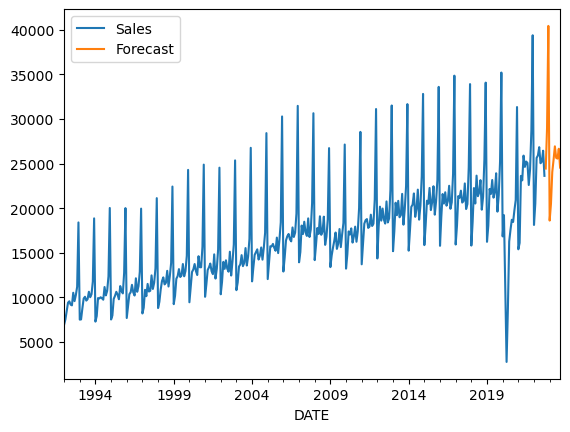

In [47]:
ax = df.plot()
forecast_df.plot(ax=ax)